In [ ]:
pip install datasets

In [ ]:
import os
import random
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import BertConfig
import torch
from google.colab import drive
from transformers import Trainer, TrainingArguments

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_dir = "/content/drive/My Drive/dataset (1)/"

In [ ]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
import os
from transformers import BartTokenizer, BartForConditionalGeneration
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Step 1: Prepare Your Data
judgment_folder = "/content/drive/MyDrive/dataset (1)/judgement"
summary_folder = "/content/drive/MyDrive/dataset (1)/summary"

judgment_files = os.listdir(judgment_folder)
summary_files = os.listdir(summary_folder)

# Step 2: Load and Preprocess the Data
judgment_texts = []
summary_texts = []

for judgment_file in judgment_files:
    with open(os.path.join(judgment_folder, judgment_file), "r", encoding="utf-8") as file:
        judgment_texts.append(file.read())

for summary_file in summary_files:
    with open(os.path.join(summary_folder, summary_file), "r", encoding="utf-8") as file:
        summary_texts.append(file.read())

# Split the dataset into training and testing sets
judgments_train, judgments_test, summaries_train, summaries_test = train_test_split(judgment_texts, summary_texts, test_size=0.2, random_state=42)

# Create datasets
train_dataset = Dataset.from_dict({"judgments": judgments_train, "summaries": summaries_train})
test_dataset = Dataset.from_dict({"judgments": judgments_test, "summaries": summaries_test})

# Tokenize and encode the datasets
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

def tokenize_function(example):
    tokenized_judgments = tokenizer(example["judgments"], padding="max_length", truncation=True, max_length=512)
    tokenized_summaries = tokenizer(example["summaries"], padding="max_length", truncation=True, max_length=512)
    return {"input_ids": tokenized_judgments["input_ids"],
            "attention_mask": tokenized_judgments["attention_mask"],
            "labels": tokenized_summaries["input_ids"]}

train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_function, batched=True)

# Step 3: Fine-Tune the BART Model
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

# Fine-tune the model
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    predict_with_generate=True,
    evaluation_strategy="steps",
    save_strategy="epoch",
    num_train_epochs=10,
    logging_dir="/content/drive/MyDrive/logs",
    logging_steps=1000,
    save_total_limit=3,
    overwrite_output_dir=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=test_tokenized_dataset,
)

trainer.train()

# Step 4: Evaluate the Model (if needed)
results = trainer.evaluate()

print(results)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_

{'eval_loss': 2.9453682899475098, 'eval_runtime': 2.6474, 'eval_samples_per_second': 7.555, 'eval_steps_per_second': 1.889, 'epoch': 10.0}


In [ ]:
# Define the directory where you want to save the model
output_dir = "/content/drive/MyDrive/results"

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the trainer object
trainer.save_model(output_dir)

print("Trained model saved successfully!")


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


Trained model saved successfully!


In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer

# Load the model configuration
model_config = "/content/drive/MyDrive/results/config.json"

# Load the model's learned parameters
model_checkpoint = "/content/drive/MyDrive/results"

# Initialize the model
model = BartForConditionalGeneration.from_pretrained(model_checkpoint, config=model_config)

# Initialize the tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

# Read the text from the file
input_file_path = "/content/23.txt"
with open(input_file_path, "r", encoding="utf-8") as file:
    input_text = file.read()

# Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True)

# Generate a summary
summary_ids = model.generate(inputs["input_ids"], num_beams=4, max_length=512, early_stopping=True)

# Decode the generated summary
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print("Generated Summary:", summary)


Generated Summary: Section 3 (1) of the Patiala and East Punjab States Union General Provisions (Administration) Ordinance (No. XVI of 2005) which came into force on February 2, 1949, and re enacted section 3 of an earlier Ordinance which was in force from August 20, 1948, provided that as from the appointed day (i.e., August 30, 1948) all laws in force in the Patials shall apply to 17 128 the territories of the said Union.
In one of the Covenanting States, viz., Kapurthala, there was a law of income tax in force on the said date, the rate of tax payable under which was lower than that payable under the Patuala Income tax Act, and in another Covenanting State, Nabha there was no law of Income tax at all.
The petitioner who was an asses see residing in Nabha and who was assessed under thepatiala Act applied under article 32 of the Constitution for a writ in the nature of a writ of certiorari quashing the assessment on the ground (i) that he had been denied the fundamental right of equal

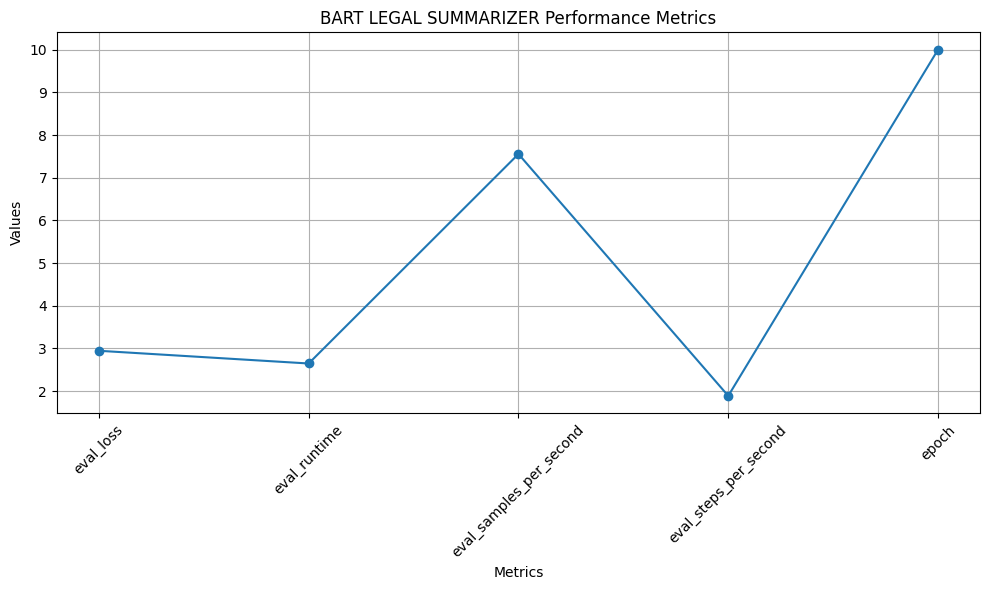

In [ ]:
import matplotlib.pyplot as plt

# Data
metrics = {
    'eval_loss': 2.9453682899475098,
    'eval_runtime': 2.6474,
    'eval_samples_per_second': 7.555,
    'eval_steps_per_second': 1.889,
    'epoch': 10.0
}

# Extract metric names and values
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(metric_names, metric_values, marker='o', linestyle='-')
plt.title('BART LEGAL SUMMARIZER Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


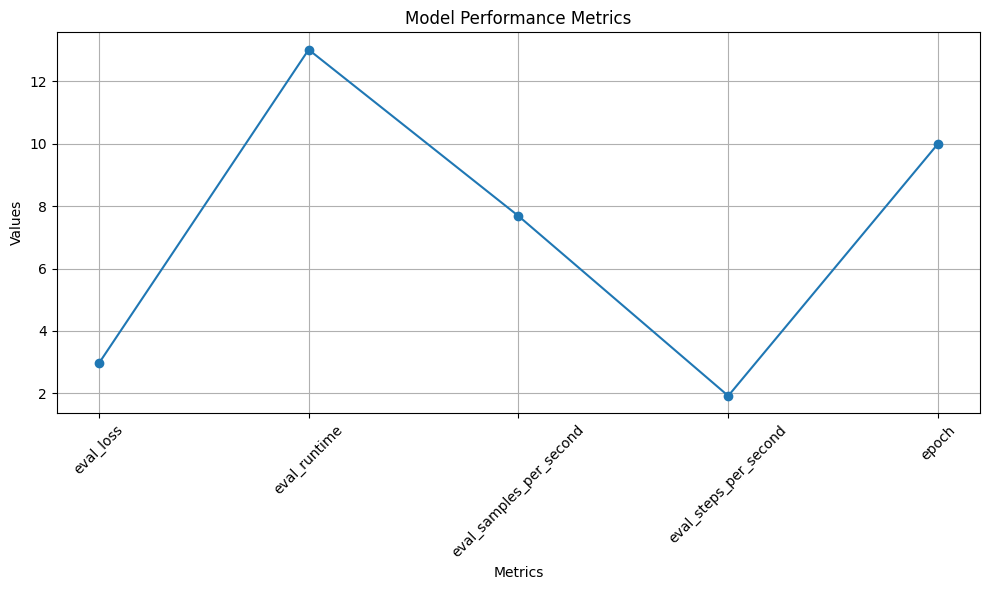

In [ ]:
import matplotlib.pyplot as plt

# Data
metrics = {
    'eval_loss': 2.9619128704071045,
    'eval_runtime': 13.0144,
    'eval_samples_per_second': 7.684,
    'eval_steps_per_second': 1.921,
    'epoch': 10.0
}

# Extract metric names and values
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(metric_names, metric_values, marker='o', linestyle='-')
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


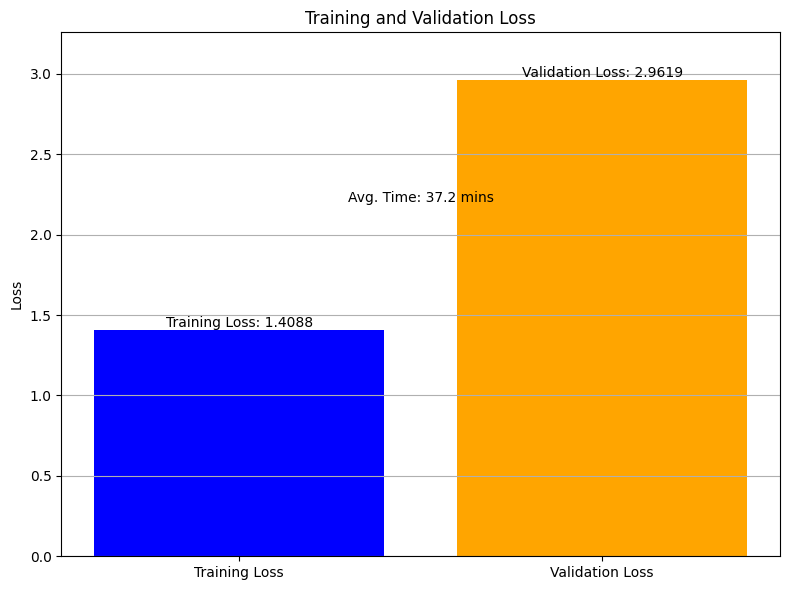

In [ ]:
import matplotlib.pyplot as plt

# Data
training_loss = 1.408800
validation_loss = 2.961913
average_time_minutes = 37.2

# Plotting
plt.figure(figsize=(8, 6))

# Plotting the loss values
plt.bar(['Training Loss', 'Validation Loss'], [training_loss, validation_loss], color=['blue', 'orange'])
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Annotating average time taken
plt.text(0, training_loss, f'Training Loss: {training_loss:.4f}', ha='center', va='bottom')
plt.text(1, validation_loss, f'Validation Loss: {validation_loss:.4f}', ha='center', va='bottom')
plt.text(0.5, (training_loss + validation_loss) / 2, f'Avg. Time: {average_time_minutes} mins', ha='center', va='bottom')

plt.ylim(0, max(training_loss, validation_loss) * 1.1)  # Set y-axis limit

plt.grid(axis='y')  # Add gridlines for better readability
plt.tight_layout()
plt.show()
